# Implementing Multiprocessing with Christian Kindler's TensorFlow/Keras Curve Fitter

## Setup
All work towards this objective is currently on the `warp_speed` branch of the [BiT lppls repo](https://github.com/Boulder-Investment-Technologies/lppls.git). You'll need to clone that repo to your local machine, checkout the `warp_speed` branch and import it as a package.

```
git clone https://github.com/Boulder-Investment-Technologies/lppls.git lppls_local
cd lppls_local
git checkout warp_speed
```

Then you should be good to import the local package as long as it is in your `sys.path`.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K, Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad, SGD
from sklearn.preprocessing import MinMaxScaler

import multiprocessing
import time

# importing local version of cloned lppls package 
# (https://github.com/Boulder-Investment-Technologies/lppls.git)
if '/Users/joshnielsen/projects/lppls_local' not in sys.path:
    sys.path.append('/Users/joshnielsen/projects/lppls_local')

from lppls import lppls_layer

In [2]:
# read the downloaded data (same dataset from medium article: 
# https://medium.com/@ch9.ki7/lppl-or-arbitrary-curve-fitting-with-tensorflow-and-keras-9a8123f504f2)
df = pd.read_csv('~/downloads/SPY.csv', 
                 index_col='Date', 
                 parse_dates=True)

df.fillna(method='ffill', inplace=True)

# LPPLS works better with log prices
x = np.log(df['Close'].values)

# fits should be more stable if we always use the same domain
x = MinMaxScaler().fit_transform(x.reshape(-1, 1))

# reshape data into keras batch format 
x = x.reshape(1, -1)

## Create a Single Fit

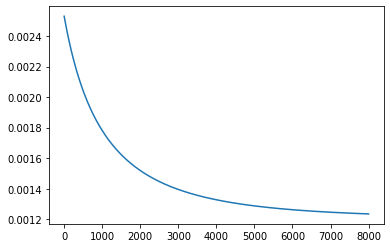

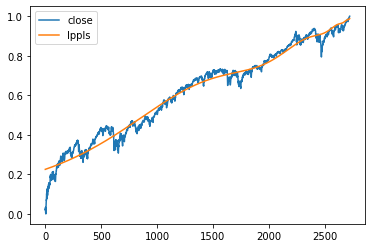

In [3]:
model = Sequential([lppls_layer.LPPLSLayer()])
model.compile(loss='mse', optimizer=Adagrad(0.011))
hist = model.fit(x, x, epochs=8000, verbose=0)

plt.plot(hist.history["loss"])
plt.show()

res = pd.DataFrame({"close": x[0], 
        "lppls": model.predict_on_batch(x)
       })
res.plot()

## Create Many Fits on Shrinking Windows (compute LPPLS Indicators)

In [4]:
def _func_compute_indicator(args):
    cofs = []
    x, largest_window_size, smallest_window_size, increment = args
    
    j = smallest_window_size
    bew_true_count = 0
    bef_true_count = 0

    while j <= largest_window_size:
        x_slice = x[0:j]
        x_slice = x_slice.reshape(1, -1)
        j = j + increment

        # create the model
        model = Sequential([lppls_layer.LPPLSLayer()])
        model.compile(loss='mse', optimizer=Adagrad(0.011))
        model.fit(x_slice, x_slice, epochs=8000, verbose=0)

        tc = model.layers[0].get_tc()
        m = model.layers[0].get_m()
        w = model.layers[0].get_w()
        args = (tc, m, w)

        t, tc, m, w, a, b, c1, c2 = model.layers[0].get_t_tc_m_w_abcc(x_slice, args)
        c = (c1 ** 2 + c2 ** 2) ** 0.5

        first = t.numpy()[0]
        last = t.numpy()[-1]
        dt = last - first
        dmin = last - dt * 0.05
        dmax = last + dt * 0.1

        n_oscillation = (w / (2 * np.pi)) * np.log(abs((tc - first) / (tc - last)))
        damping = (m * abs(b)) / (w * abs(c))

        # for bubble early warning
        bew_true = (damping > 0.8) and (0.01 < m < 1.2) and (2 < w < 25) and (dmin < tc < dmax) and (n_oscillation > 2.5)
        bew_true_count = (bew_true_count + 1) if bew_true else bew_true_count

        # for bubble end flag
        bef_true = (damping > 1) and (0.01 < m < 0.99) and (2 < w < 25) and (dmin < tc < dmax) and (n_oscillation > 2.5)
        bef_true_count = (bef_true_count + 1) if bef_true else bef_true_count

    cofs.append({end_index: {
        'bew': bew_true_count/(largest_window_size-smallest_window_size),
        'bef': bef_true_count/(largest_window_size-smallest_window_size)
    }})
    
    return cofs
            


def mp_compute_indicator(workers, x, largest_window_size=120, smallest_window_size=30, increment=5):

    x_len = len(x[0, :]) - smallest_window_size

    func = _func_compute_indicator
    func_arg_map = [(
        x[:, i:largest_window_size + i], # x (window)
        largest_window_size,             # largest_window_size
        smallest_window_size,            # smallest_window_size
        increment,                       # increment
    ) for i in range(x_len)]

    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(func, func_arg_map)
    pool.close()

    return result

start = time.time()
indicators = mp_compute_indicator(8, x)
print(indicators)
end = time.time()
print(end - start)

KeyboardInterrupt: 